# Integrating gene expression and chromatin accessibility of 10k PBMCs

Please see [the first chapter where getting the data and processing RNA modality are described](https://github.com/gtca/muon-tutorials/blob/master/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.ipynb) and [the second chapter with ATAC modality processing](https://github.com/gtca/muon-tutorials/blob/master/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.ipynb)


This is the third chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, we will see how to learn a latent space jointly on two omics.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

## Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import muon as mu

Load the MuData object from the `.h5mu` file:

In [4]:
mdata = mu.read("data/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11168 × 132435
  var:	'dispersions', 'dispersions_norm', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'interval', 'mean', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'std', 'total_counts'
  2 modalities
    atac:	9765 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	10915 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'c

In each modality, only cells passing respective QC are retained. For the multimodal data integration, we will use only cells that are present for both modalities:

In [5]:
mu.pp.intersect_obs(mdata)

In [6]:
mdata.shape

(9512, 132435)

## Compare cell type annotation

Before performing the integration, we can compare how the cell type annotations in individual modalities match each other.

We can calculate a general score that compares those clustering solutions, e.g. [the adjusted Rand index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [7]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:celltype'], mdata.obs['atac:celltype'])

0.7457983340058714

We can also look into how those cell type annotations match per cell type:

In [8]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:celltype").
        size().
        reset_index(name="n_total").
        set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:celltype", "rna:celltype"]).
        size().
        reset_index(name="n").
        set_index("atac:celltype").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)

We can now make a wide table and visualise it with a heatmap.

In [9]:
df_wide = df_frac.set_index("atac:celltype").pivot(columns="rna:celltype", values="frac")

<AxesSubplot:xlabel='rna:celltype', ylabel='atac:celltype'>

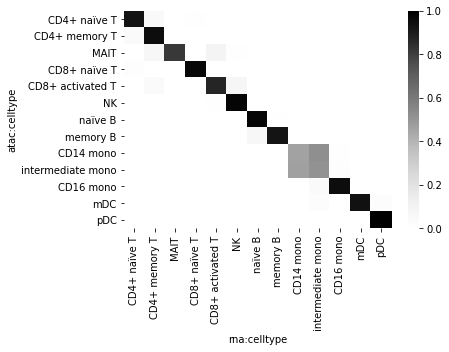

In [10]:
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")

It seems that cell types are highly reproducible across modalities with the only exception of the CD14/intermediate monocytes annotation that doesn't seem particularly confident — most probably in the ATAC modality. One can check that the adjusted Rand index goes up to `0.92` when those two groups of cells are treated as one cell types.

## Perform integration

We will now run **multi-omic factor analysis** — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities. Intuitively, it can be viewed as a generalisation of PCA for multi-omics data. More information about this method can be found [on the MOFA website](https://biofam.github.io/MOFA2/).

The time required to train the model depends on the number of cells and features as well as on hardware specs. For the current dataset, it takes 4 minutes on the GeForce RTX 2080 Ti NVIDIA card. Only highly variable features are used by default.

In [11]:
mu.tl.mofa(mdata, outfile="models/pbmc10k_rna_atac.hdf5")

In [12]:
# # NOTE: if you wish to load the trained model,
# #       use mofax library to quickly add 
# #       factors and weights matrices 
# #       to the mdata object
# # 
# import mofax as mfx
# model = mfx.mofa_model('models/pbmc10k_rna_atac.hdf5')
# mdata.obsm["X_mofa"] = model.get_factors()

# # If only highly variable features were used
# w = model.get_weights()
# # Set the weights of features that were not used to zero
# mdata.varm["LFs"] = np.zeros(shape=(mdata.n_vars, w.shape[1]))
# mdata.varm["LFs"][mdata.var["highly_variable"]] = w

# model.close()

In [13]:
mdata

MuData object with n_obs × n_vars = 9512 × 132435
  var:	'dispersions', 'dispersions_norm', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'interval', 'mean', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'std', 'total_counts'
  obsm:	'X_mofa'
  varm:	'LFs'
  2 modalities
    atac:	9512 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9512 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 

After the training, the embedding will be added to the `obsm` slot of the `mdata`:

In [14]:
mdata.obsm['X_mofa'].shape

(9512, 10)

We can directly use it for plotting with `mu.pl` or `sc.pl` plotting functions — `mdata` has both `.obs` and `.obsm` slots that are needed for plotting with the latter one.

In [15]:
# Copy colours that were defined previously
mdata.uns = mdata.uns or dict()
mdata.uns['rna:celltype_colors'] = mdata['rna'].uns['celltype_colors']
mdata.uns['atac:celltype_colors'] = mdata['atac'].uns['celltype_colors']

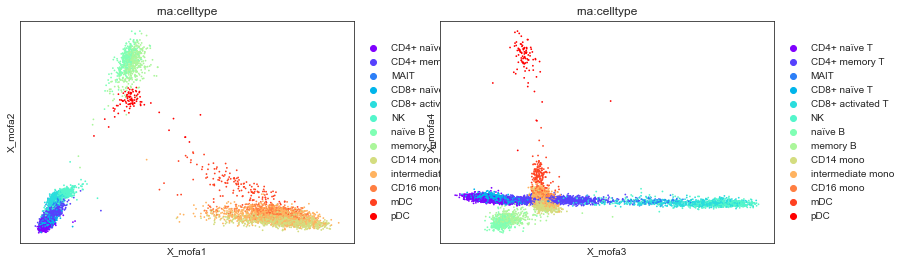

In [16]:
mu.pl.mofa(mdata, color="rna:celltype", components=["1,2", "3,4"])
# 'rna:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['rna'].obs

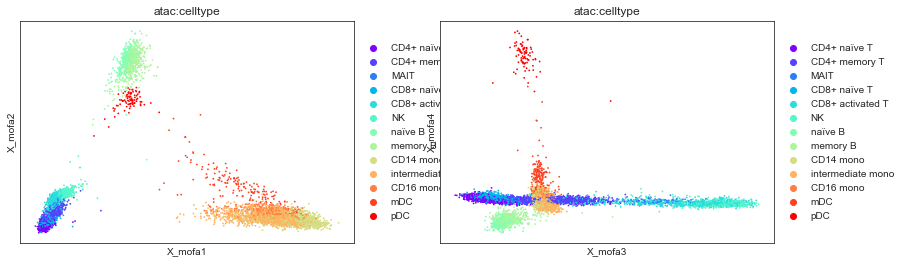

In [17]:
mu.pl.mofa(mdata, color="atac:celltype", components=["1,2", "3,4"])
# 'atac:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['atac'].obs

We can then use this embedding not only to compare cell type annotation performed individually on each modality but also to annotate cell types based on both omics jointly.

To visualise all the factors together, we'll use a non-linear dimensionality reduction method such as UMAP to display the embedding in 2D:

In [18]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)

In [19]:
sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)

For instance, we can then visualise how cell type annotations performed on individual modalities correspond to this 2D projection of the joint MOFA embeddings:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'rna:mt' as categorical
... storing 'feature_types' as categorical
... storing 'interval' as categorical


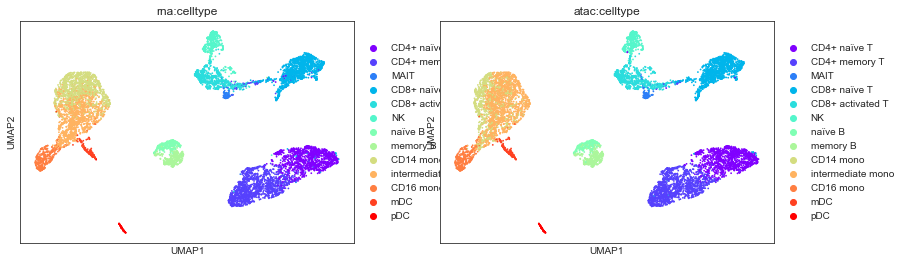

In [20]:
sc.pl.umap(mdata, color=["rna:celltype", "atac:celltype"])

Conventional clustering can now be performed based on the MOFA embeddings and also can be visualised on the same UMAP:

In [21]:
sc.tl.leiden(mdata, key_added='leiden_joint')

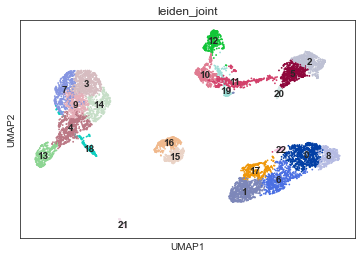

In [22]:
sc.pl.umap(mdata, color="leiden_joint", legend_loc='on data')

Individual features from modalities are also available when plotting embeddings:

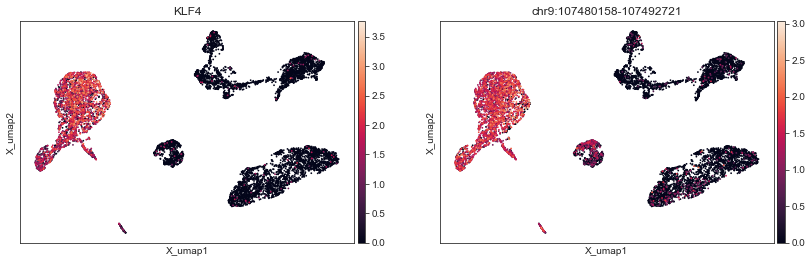

In [23]:
mu.pl.umap(mdata, color=["KLF4", "chr9:107480158-107492721"])

We can also generate custom plots with `matplotlib` and `seaborn`:

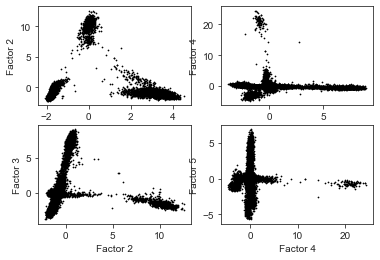

In [24]:
df = pd.DataFrame(mdata.obsm["X_mofa"])
df.columns = [f"Factor {i+1}" for i in range(df.shape[1])]

plot_scatter = lambda i, ax: sns.scatterplot(data=df, x=f"Factor {i+1}", y=f"Factor {i+2}", color="black", linewidth=0, s=3, ax=ax)

fig, axes = plt.subplots(2, 2)
for i in range(4):
    plot_scatter(i, axes[i%2][i//2])

## Annotate cell types

We will now define cell types based on both omics.

In [25]:
mdata['rna'].obs['leiden_joint'] = mdata.obs.leiden_joint
mdata['atac'].obs['leiden_joint'] = mdata.obs.leiden_joint

### Ranking genes and peaks

In [26]:
sc.tl.rank_genes_groups(mdata['rna'], 'leiden_joint', method='t-test_overestim_var')

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [27]:
from muon import atac as ac
ac.tl.rank_peaks_groups(mdata['atac'], 'leiden_joint', method='t-test_overestim_var')

### Listing differentially expressed genes and differentially accessible peaks

In [28]:
result = {}
result['rna'] = mdata['rna'].uns['rank_genes_groups']
result['rna']['genes'] = result['rna']['names']
result['atac'] = mdata['atac'].uns['rank_genes_groups']

groups = result['rna']['names'].dtype.names
pd.set_option("max_columns", 200)
pd.DataFrame(
    {mod + ':' + group + '_' + key[:1]: result[mod][key][group][:10]
    for group in groups for key in ['names', 'genes', 'pvals']
    for mod in mdata.mod.keys()})

,atac:0_n,rna:0_n,atac:0_g,rna:0_g,atac:0_p,rna:0_p,atac:1_n,rna:1_n,atac:1_g,rna:1_g,atac:1_p,rna:1_p,atac:2_n,rna:2_n,atac:2_g,rna:2_g,atac:2_p,rna:2_p,atac:3_n,rna:3_n,atac:3_g,rna:3_g,atac:3_p,rna:3_p,atac:4_n,rna:4_n,atac:4_g,rna:4_g,atac:4_p,rna:4_p,atac:5_n,rna:5_n,atac:5_g,rna:5_g,atac:5_p,rna:5_p,atac:6_n,rna:6_n,atac:6_g,rna:6_g,atac:6_p,rna:6_p,atac:7_n,rna:7_n,atac:7_g,rna:7_g,atac:7_p,rna:7_p,atac:8_n,rna:8_n,atac:8_g,rna:8_g,atac:8_p,rna:8_p,atac:9_n,rna:9_n,atac:9_g,rna:9_g,atac:9_p,rna:9_p,atac:10_n,rna:10_n,atac:10_g,rna:10_g,atac:10_p,rna:10_p,atac:11_n,rna:11_n,atac:11_g,rna:11_g,atac:11_p,rna:11_p,atac:12_n,rna:12_n,atac:12_g,rna:12_g,atac:12_p,rna:12_p,atac:13_n,rna:13_n,atac:13_g,rna:13_g,atac:13_p,rna:13_p,atac:14_n,rna:14_n,atac:14_g,rna:14_g,atac:14_p,rna:14_p,atac:15_n,rna:15_n,atac:15_g,rna:15_g,atac:15_p,rna:15_p,atac:16_n,rna:16_n,atac:16_g,rna:16_g,atac:16_p,rna:16_p,atac:17_n,rna:17_n,atac:17_g,rna:17_g,atac:17_p,rna:17_p,atac:18_n,rna:18_n,atac:18_g,rna:18_g,atac:18_p,rna:18_p,atac:19_n,rna:19_n,atac:19_g,rna:19_g,atac:19_p,rna:19_p,atac:20_n,rna:20_n,atac:20_g,rna:20_g,atac:20_p,rna:20_p,atac:21_n,rna:21_n,atac:21_g,rna:21_g,atac:21_p,rna:21_p,atac:22_n,rna:22_n,atac:22_g,rna:22_g,atac:22_p,rna:22_p
0,chr14:99255246-99275454,LEF1,"BCL11B, AL109767.1",LEF1,8.438309e-63,2.442371e-130,chr6:137715217-137718150,INPP4B,"AL356234.2, LINC02539",INPP4B,1.341573e-65,3.133586e-142,chr2:86783559-86792275,LEF1,CD8A,LEF1,2.991441e-130,7.030922e-148,chr9:107480158-107492721,VCAN,KLF4,VCAN,1.514428e-125,1.684183e-264,chr9:107480158-107492721,SLC8A1,KLF4,SLC8A1,2.417349e-96,3.736816e-192,chr2:86783559-86792275,BACH2,CD8A,BACH2,6.215390e-92,3.212512e-114,chr14:99255246-99275454,INPP4B,"BCL11B, AL109767.1",INPP4B,4.790166e-45,6.537422e-139,chr20:50269694-50277398,VCAN,SMIM25,VCAN,8.811276e-80,1.446464e-194,chr14:99255246-99275454,LEF1,"BCL11B, AL109767.1",LEF1,4.219380e-49,1.268213e-87,chr9:107480158-107492721,PLXDC2,KLF4,PLXDC2,1.360803e-85,4.643975e-115,chr1:184386243-184389335,CCL5,"C1orf21, AL445228.2",CCL5,2.674621e-73,3.779073e-257,chr2:86783559-86792275,CCL5,CD8A,CCL5,9.833715e-48,1.683454e-93,chr17:83076201-83103570,GNLY,"METRNL, AC130371.2",GNLY,1.464539e-95,2.512159e-300,chr2:16653069-16660704,FCGR3A,FAM49A,FCGR3A,6.194099e-62,5.207895e-237,chr9:107480158-107492721,PLXDC2,KLF4,PLXDC2,4.280707e-38,3.497046e-103,chr2:231669797-231676530,BANK1,PTMA,BANK1,1.637270e-119,1.245263e-299,chr22:41917087-41929835,IGHM,TNFRSF13C,IGHM,2.367636e-92,6.200262e-302,chr10:33135632-33141841,IL32,IATPR,IL32,1.571908e-18,1.061190e-43,chr1:220876295-220883526,CST3,"HLX, HLX-AS1",CST3,8.837247e-29,3.276288e-77,chr11:114072228-114076352,NKG7,ZBTB16,NKG7,5.263514e-32,1.790101e-56,chr2:86783559-86792275,LEF1,CD8A,LEF1,0.000002,8.856198e-22,chr17:81425658-81431769,TCF4,BAHCC1,TCF4,3.739753e-36,1.641340e-99,chr20:44066714-44073458,FHIT,"TOX2, AL035447.1",FHIT,0.001339,6.461786e-14
1,chr14:99223600-99254668,FHIT,"BCL11B, AL109767.1",FHIT,5.960695e-54,6.110806e-126,chr1:1210271-1220028,IL7R,"SDF4, TNFRSF4",IL7R,2.685949e-64,6.501053e-135,chr12:10552886-10555668,NELL2,LINC02446,NELL2,7.674191e-114,5.043340e-146,chr6:41268623-41279829,PLXDC2,TREM1,PLXDC2,4.615210e-103,1.179676e-227,chr20:50269694-50277398,TYMP,SMIM25,TYMP,6.595060e-80,1.036221e-166,chr12:10552886-10555668,LEF1,LINC02446,LEF1,6.824578e-60,7.217206e-117,chr14:22536559-22563070,ANK3,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",ANK3,7.744505e-40,1.133036e-104,chr20:1943201-1947850,PLXDC2,PDYN-AS1,PLXDC2,2.451617e-76,1.028900e-153,chr14:99181080-99219442,FHIT,"BCL11B, AL162151.1",FHIT,1.741674e-45,4.523144e-90,chr1:212604203-212626574,NAMPT,"FAM71A, ATF3, AL590648.2",NAMPT,3.476135e-73,4.237109e-115,chr4:6198055-6202103,NKG7,"JAKMIP1, C4orf50",NKG7,2.087277e-69,1.109701e-229,chr1:24909406-24919504,PRKCH,RUNX3,PRKCH,4.776232e-34,3.791643e-53,chr1:184386243-184389335,PRF1,"C1orf21, AL445228.2",PRF1,1.508249e-73,1.206868e-219,chr5:1476663-1483241,TCF7L2,"SLC6A3, LPCAT1

### Assigning cell type labels

Having studied markers of individual clusters, we can add a new cell type annotation to the object.

In [29]:
new_cluster_names = {
    "0": "CD4+ naïve T", "8": "CD4+ naïve T", "22": "CD4+ naïve T",
    "1": "CD4+ memory T", "6": "CD4+ memory T", "17": "CD4+ memory T",
    "2": "CD8+ naïve T", "5": "CD8+ naïve T", "20": "CD8+ naïve T",
    "10": "CD8+ cytotoxic effector T", "11": "CD8+ transitional effector T",
    "19": "MAIT", "12": "NK",
    
    "16": "naïve B", "15": "memory B",
    
    "3": "classical mono", "7": "classical mono", "9": "classical mono", "14": "classical mono", 
    "4": "intermediate mono", "13": "non-classical mono",
    "18": "mDC", "21": "pDC",
}

mdata.obs['celltype'] = mdata.obs.leiden_joint.astype("str")
mdata.obs.celltype = mdata.obs.celltype.map(new_cluster_names).astype("category")

We will also re-order categories for the next plots:

In [30]:
mdata.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T',
    'CD8+ naïve T', 'CD8+ transitional effector T', 'CD8+ cytotoxic effector T',
    'MAIT', 'NK',
    'naïve B', 'memory B',
    'classical mono', 'intermediate mono', 'non-classical mono',
    'mDC', 'pDC'], inplace=True)

... and take colours from a palette:

In [31]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(mdata.obs.celltype.cat.categories)))

mdata.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

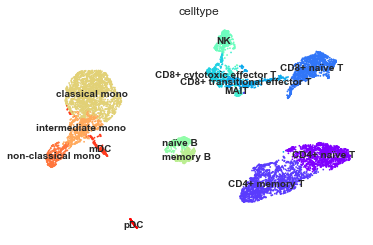

In [32]:
mu.pl.umap(mdata, color="celltype", legend_loc="on data", frameon=False)

### Visualising markers

In [33]:
mdata['rna'].obs['celltype_joint'] = mdata.obs.celltype
mdata['atac'].obs['celltype_joint'] = mdata.obs.celltype

Finally, we'll visualise some marker genes across cell types.

In [34]:
marker_genes = [
    'IL7R', 'TRAC', 'GATA3',                                # CD4+ T
    'LEF1', 'FHIT', 'RORA', 'ITGB1',                        # naïve/memory
    'CD8A', 'CD8B', 'CD248', 'CCL5',                        # CD8+ T
    'GZMH', 'GZMK',                                         # cytotoxic/transitional effector T cells
    'KLRB1', 'SLC4A10',                                     # MAIT
    'IL32',                                                 # T/NK
    'GNLY', 'NKG7',                                         # NK
    'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'IL4R', 'TNFRSF13C',  # B
    'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',               # mono
    'DPYD', 'ITGAM',                                        # classical/intermediate/non-classical mono
    'FCGR3A', 'MS4A7', 'CST3',                              # non-classical mono
    'CLEC10A', 'IRF8', 'TCF4'                               # DC
]

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


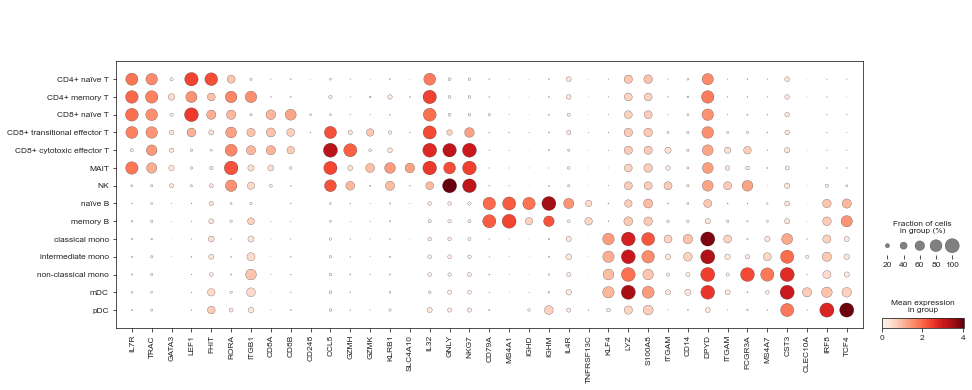

In [35]:
sc.pl.dotplot(mdata['rna'], marker_genes, 'celltype_joint')

In [36]:
marker_peaks = [
    'chr14:99255246-99275454', 'chr10:33135632-33141841',                              # T/NK
    'chr1:1210271-1220028',                                                            # memory T/NK
    'chr2:86783559-86792275',                                                          # CD8+ T/NK
    'chr12:10552886-10555668',                                                         # naïve CD8+ T
    'chr11:114072228-114076352',                                                       # MAIT/NK
    'chr5:150385442-150415310',                                                        # B and mono (CD74)
    'chr22:41931503-41942227', 'chr22:41917087-41929835', 'chr6:167111604-167115345',  # B
    'chr9:107480158-107492721', 'chr5:1476663-1483241',                                # mono
    'chr10:75399596-75404660', 'chr1:220876295-220883526',                             # mDC
    'chr17:81425658-81431769', 'chr7:98641522-98642532',                               # pDC
]

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


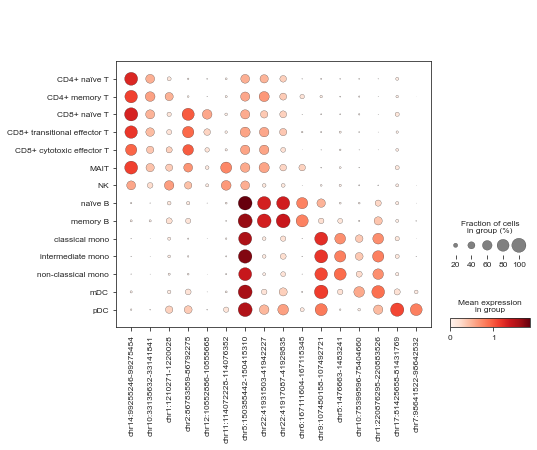

In [37]:
sc.pl.dotplot(mdata['atac'], marker_peaks, 'celltype_joint')

## Saving progress on disk

In this notebook we have filtered cells and added MOFA factors & things based on them (neighbourhood graph, clusters, UMAP) to the `mdata` object, and we'll finally save our progress on disk:

In [38]:
mdata.write("data/pbmc10k.h5mu")

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


For a more detailed exploration of the trained MOFA model in Python, please see [this notebook](https://github.com/gtca/muon-tutorials/blob/master/single-cell-rna-atac/pbmc10k/3.1-MOFA-Model-Interpretation.ipynb) that demonstrated how to use [mofa×](https://github.com/bioFAM/mofax) to interpret the MOFA model that we've trained on the ATAC+RNA multi-omics data.
